# Optimization Algorithms

1) Vanilla Gradient Descent <br>
2) Gradient Descent with Momentum <br>
3) RMSprop <br>
4) Adam <br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

F:\Conda_Scripts\deeplearning.ai\02_Improving_Deep_Neural_Networks\02\opt_utils.py:76: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], layer_dims[l-1])
F:\Conda_Scripts\deeplearning.ai\02_Improving_Deep_Neural_Networks\02\opt_utils.py:77: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], 1)


### Gradient Descent

A simple optimization method in machine learning is gradient descent (GD). When you take gradient steps with respect to all $m$ examples on each step, it is also called Batch Gradient Descent.

In [31]:
def update_parameters_with_gd(parameters, grads, learning_rate):
    """
    Update parameters using one step of gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters to be updated:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients to update each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    learning_rate -- the learning rate, scalar.
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    
    num_layers = len(parameters.keys()) // 2
    
    for curr_layer in range(1, num_layers):
        parameters['W' + str(curr_layer)] -= (learning_rate * grads['dW' + str(curr_layer)])
        parameters['b' + str(curr_layer)] -= (learning_rate * grads['db' + str(curr_layer)])
    
    return parameters

In [32]:
parameters, grads, learning_rate = update_parameters_with_gd_test_case()

parameters = update_parameters_with_gd(parameters, grads, learning_rate)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 1.63535156 -0.62320365 -0.53718766]
 [-1.07799357  0.85639907 -2.29470142]]
b1 = [[ 1.74604067]
 [-0.75184921]]
W2 = [[ 0.3190391  -0.24937038  1.46210794]
 [-2.06014071 -0.3224172  -0.38405435]
 [ 1.13376944 -1.09989127 -0.17242821]]
b2 = [[-0.87785842]
 [ 0.04221375]
 [ 0.58281521]]


### Mini-Batch Gradient descent

There are two steps in creating mini-batches from the entire dataset:
1) Random Shuffle
2) Partition according to T

In [4]:
def random_mini_batches(X, y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    mini_batches = []
    m = X.shape[1]
    permutations = list(np.random.permutation(m))
    shuffled_X = X[:, permutations]
    shuffled_y = y[:, permutations]
    
    num_complete_batches = m // mini_batch_size
    
    for i in range(num_complete_batches):
        
        mini_X = shuffled_X[:, (i * mini_batch_size):((i+1) * mini_batch_size)]
        mini_y = shuffled_y[:, (i * mini_batch_size):((i+1) * mini_batch_size)]
        
        mini_batch = (mini_X, mini_y)
        mini_batches.append(mini_batch)
        
    if m % mini_batch_size != 0:
        last_mini_X = shuffled_X[:, (num_complete_batches * mini_batch_size):]
        last_mini_y = shuffled_y[:, (num_complete_batches * mini_batch_size):]
        last_mini_batch = (last_mini_X, last_mini_y)
        mini_batches.append(last_mini_batch)
        
    return mini_batches
    
    
    

In [5]:
X_assess, Y_assess, mini_batch_size = random_mini_batches_test_case()
mini_batches = random_mini_batches(X_assess, Y_assess, mini_batch_size)

print("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: (12288, 64)
shape of the 2nd mini_batch_X: (12288, 64)
shape of the 3rd mini_batch_X: (12288, 20)
shape of the 1st mini_batch_Y: (1, 64)
shape of the 2nd mini_batch_Y: (1, 64)
shape of the 3rd mini_batch_Y: (1, 20)
mini batch sanity check: [-0.67124613  0.74055645 -0.63699565]


### Momentum

Because mini-batch gradient descent makes a parameter update after seeing just a subset of examples, the direction of the update has some variance, and so the path taken by mini-batch gradient descent will "oscillate" toward convergence. Using momentum can reduce these oscillations.

Momentum takes into account the past gradients to smooth out the update. We will store the 'direction' of the previous gradients in the variable $v$. Formally, this will be the exponentially weighted average of the gradient on previous steps. You can also think of $v$ as the "velocity" of a ball rolling downhill, building up speed (and momentum) according to the direction of the gradient/slope of the hill.

In [6]:
def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """
    
    v = {}
    num_layers = len(parameters.keys()) // 2
    
    for curr_layer in range(1, num_layers+1):
        v['dW' + str(curr_layer)] = np.zeros_like(parameters['W' + str(curr_layer)])
        v['db' + str(curr_layer)] = np.zeros_like(parameters['b' + str(curr_layer)])
        
    return v

In [7]:
parameters = initialize_velocity_test_case()
print(parameters.keys())

v = initialize_velocity(parameters)
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))

dict_keys(['W1', 'W2', 'b2', 'b1'])
v["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = [[0.]
 [0.]]
v["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = [[0.]
 [0.]
 [0.]]


In [8]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """
    # vdW = beta * vdW + (1-beta) * dW
    # W = W - (alpha * vdw)
    
    num_layers = len(parameters.keys()) // 2
    
    for curr_layer in range(1, num_layers + 1):
        #######Get the values##########
        vdW = v['dW' + str(curr_layer)]
        vdb = v['db' + str(curr_layer)]
        
        dW = grads['dW' + str(curr_layer)]
        db = grads['db' + str(curr_layer)]
        
        W = parameters['W' + str(curr_layer)]
        b = parameters['b' + str(curr_layer)]
        ################################
        
        ##########Compute Momentum########
        vdW = (beta * vdW) + (1 - beta) * dW
        W = W - (learning_rate * vdW)
        
        vdb = (beta * vdb) + (1 - beta) * db
        b = (b - learning_rate * vdb)
        ##################################
        
        #######Update dictionaries#######
        v['dW' + str(curr_layer)] = vdW
        v['db' + str(curr_layer)] = vdb
        
        parameters['W' + str(curr_layer)] = W
        parameters['b' + str(curr_layer)] = b
        #################################
        
    return parameters, v
    

In [9]:
parameters, grads, v = update_parameters_with_momentum_test_case()

parameters, v = update_parameters_with_momentum(parameters, grads, v, beta = 0.9, learning_rate = 0.01)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))

W1 = [[ 1.62544598 -0.61290114 -0.52907334]
 [-1.07347112  0.86450677 -2.30085497]]
b1 = [[ 1.74493465]
 [-0.76027113]]
W2 = [[ 0.31930698 -0.24990073  1.4627996 ]
 [-2.05974396 -0.32173003 -0.38320915]
 [ 1.13444069 -1.0998786  -0.1713109 ]]
b2 = [[-0.87809283]
 [ 0.04055394]
 [ 0.58207317]]
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = [[-0.01228902]
 [-0.09357694]]
v["dW2"] = [[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = [[0.02344157]
 [0.16598022]
 [0.07420442]]


## RMSprop

In [143]:
def initialize_rmsprop(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    S -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    S['dW' + str(l)] = S of dWl
                    S['db' + str(l)] = S of dbl
    """
    
    s = {}
    num_layers = len(parameters.keys()) // 2
    
    for curr_layer in range(1, num_layers+1):
        s['dW' + str(curr_layer)] = np.zeros_like(parameters['W' + str(curr_layer)])
        s['db' + str(curr_layer)] = np.zeros_like(parameters['b' + str(curr_layer)])
        
    return s

In [145]:
parameters = initialize_velocity_test_case()

S = initialize_rmsprop(parameters)
print("S[\"dW1\"] = " + str(S["dW1"]))
print("S[\"db1\"] = " + str(S["db1"]))
print("S[\"dW2\"] = " + str(S["dW2"]))
print("S[\"db2\"] = " + str(S["db2"]))

S["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
S["db1"] = [[0.]
 [0.]]
S["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
S["db2"] = [[0.]
 [0.]
 [0.]]


In [134]:
def update_parameters_with_rmsprop(parameters, grads, s, beta, learning_rate, epsilon=1e-8):
    """
    Update parameters using RMSProp algorithm
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    S -- python dictionary containing the current S:
                    S['dW' + str(l)] = ...
                    S['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """
    # SdW = beta * SdW + (1-beta) * dW ** 2
    # W = W - (alpha * dw/sqrt(Sdw))
    
    num_layers = len(parameters.keys()) // 2
    
    for curr_layer in range(1, num_layers + 1):
        #######Get the values##########
        SdW = s['dW' + str(curr_layer)]
        Sdb = s['db' + str(curr_layer)]
        
        dW = grads['dW' + str(curr_layer)]
        db = grads['db' + str(curr_layer)]
        
        W = parameters['W' + str(curr_layer)]
        b = parameters['b' + str(curr_layer)]
        ################################
        
        #############Compute S############
        SdW = (beta * SdW) + ((1 - beta) * np.square(dW))
        W = W - (learning_rate * dW / (np.sqrt(SdW) + epsilon))
        
        Sdb = (beta * Sdb) + ((1 - beta) * np.square(db))
        b = b - (learning_rate * db / (np.sqrt(Sdb) + epsilon)) 
        ##################################
        
        #######Update dictionaries#######
        s['dW' + str(curr_layer)] = SdW
        s['db' + str(curr_layer)] = Sdb
        
        parameters['W' + str(curr_layer)] = W
        parameters['b' + str(curr_layer)] = b
        #################################
        
    return parameters, s
    

In [13]:
parameters, grads, v = update_parameters_with_momentum_test_case()

parameters, S = update_parameters_with_rmsprop(parameters, grads, v, beta = 0.9, learning_rate = 0.01)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print("S[\"dW1\"] = " + str(S["dW1"]))
print("S[\"db1\"] = " + str(S["db1"]))
print("S[\"dW2\"] = " + str(S["dW2"]))
print("S[\"db2\"] = " + str(S["db2"]))

W1 = [[ 1.65596814 -0.64337919 -0.55979453]
 [-1.1045914   0.83378485 -2.26991592]]
b1 = [[ 1.77643454]
 [-0.72958412]]
W2 = [[ 0.35066187 -0.28099315  1.49373071]
 [-2.02851793 -0.29079443 -0.35243158]
 [ 1.16539222 -1.06826849 -0.14080543]]
b2 = [[-0.90948119]
 [ 0.01059097]
 [ 0.55119244]]
S["dW1"] = [[0.12113626 0.13103924 0.08128658]
 [0.02525006 0.08115414 0.04674838]]
S["db1"] = [[0.0015102 ]
 [0.08756644]]
S["dW2"] = [[7.17640232e-03 2.81276921e-02 4.78394595e-02]
 [1.57413361e-02 4.72206320e-02 7.14372576e-02]
 [4.50571368e-02 1.60392066e-05 1.24838242e-01]]
S["db2"] = [[0.00549507]
 [0.27549433]
 [0.05506295]]


### Adam Optimization

Combines the best features of Gradient Descent with Momentum and RMSprop algorithm

In [14]:
def initialize_adam(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...
    """
    
    v = {}
    S = {}
    num_layers = len(parameters.keys()) // 2
    
    for curr_layer in range(1, num_layers+1):
        
        v['dW' + str(curr_layer)] = np.zeros_like(parameters['W' + str(curr_layer)])
        v['db' + str(curr_layer)] = np.zeros_like(parameters['b' + str(curr_layer)])
        
        S['dW' + str(curr_layer)] = np.zeros_like(parameters['W' + str(curr_layer)])
        S['db' + str(curr_layer)] = np.zeros_like(parameters['b' + str(curr_layer)])
        
    return v, S

In [15]:
parameters = initialize_adam_test_case()

v, s = initialize_adam(parameters)
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))
print("s[\"dW1\"] = " + str(s["dW1"]))
print("s[\"db1\"] = " + str(s["db1"]))
print("s[\"dW2\"] = " + str(s["dW2"]))
print("s[\"db2\"] = " + str(s["db2"]))

v["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = [[0.]
 [0.]]
v["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = [[0.]
 [0.]
 [0.]]
s["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
s["db1"] = [[0.]
 [0.]]
s["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
s["db2"] = [[0.]
 [0.]
 [0.]]


In [141]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=0.01,
                                beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    Update parameters using Adam - This function is passing the test case but fails in the real time
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    # vdW = beta1 * vdW + (1-beta1) * dW
    # SdW = beta2 * SdW + (1-beta2) * dW**2
    # vdW_corrected = vdW / (1-beta1**t)
    # SdW_corrected = SdW / (1-beta2**t)
    # W = W - (alpha * (vdW_corrected/(np.sqrt(SdW_corrected)+epsilon))
    
    num_layers = len(parameters.keys()) // 2
    alpha = learning_rate
    
    for curr_layer in range(1, num_layers + 1):
        #######Get the values##########
        vdW = v['dW' + str(curr_layer)]
        vdb = v['db' + str(curr_layer)]
        
        SdW = s['dW' + str(curr_layer)]
        Sdb = s['db' + str(curr_layer)]
        
        dW = grads['dW' + str(curr_layer)]
        db = grads['db' + str(curr_layer)]
        
        W = parameters['W' + str(curr_layer)]
        b = parameters['b' + str(curr_layer)]
        ################################
        
        ##########Compute Momentum and mov avg of squared gradient########
        vdW = (beta1 * vdW) + (1 - beta1) * dW
        vdb = (beta1 * vdb) + (1 - beta1) * db
        
        SdW = (beta2 * SdW) + (1 - beta2) * np.power(dW,2)
        Sdb = (beta2 * Sdb) + (1 - beta2) * np.power(db,2)
        ##################################################################
        
        ################Bias Correction####################
        vdW_corrected = vdW / (1 - np.power(beta1,t))
        vdb_corrected = vdb / (1 - np.power(beta1,t))
        SdW_corrected = SdW / (1 - np.power(beta2,t))
        Sdb_corrected = Sdb / (1 - np.power(beta2,t))
        ###################################################
        
        ############Compute W, b################
        W = W - ((alpha * vdW_corrected) / (np.sqrt(SdW_corrected) + epsilon))
        b = b - ((alpha * vdb_corrected) / (np.sqrt(Sdb_corrected) + epsilon))
        ########################################                                            
        
        #######Update dictionaries#######
        v['dW' + str(curr_layer)] = vdW
        v['db' + str(curr_layer)] = vdb
        
        s['dW' + str(curr_layer)] = SdW
        s['db' + str(curr_layer)] = Sdb
        
        parameters['W' + str(curr_layer)] = W
        parameters['b' + str(curr_layer)] = b
        #################################
        
    return parameters, v, s
    

In [52]:
parameters, grads, v, s = update_parameters_with_adam_test_case()
parameters, v, s  = update_parameters_with_adam(parameters, grads, v, s, t = 2)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))
print("s[\"dW1\"] = " + str(s["dW1"]))
print("s[\"db1\"] = " + str(s["db1"]))
print("s[\"dW2\"] = " + str(s["dW2"]))
print("s[\"db2\"] = " + str(s["db2"]))

W1 = [[ 1.63178673 -0.61919778 -0.53561312]
 [-1.08040999  0.85796626 -2.29409733]]
b1 = [[ 1.75225313]
 [-0.75376553]]
W2 = [[ 0.32648046 -0.25681174  1.46954931]
 [-2.05269934 -0.31497584 -0.37661299]
 [ 1.14121081 -1.09245036 -0.16498684]]
b2 = [[-0.88529978]
 [ 0.03477238]
 [ 0.57537385]]
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = [[-0.01228902]
 [-0.09357694]]
v["dW2"] = [[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = [[0.02344157]
 [0.16598022]
 [0.07420442]]
s["dW1"] = [[0.00121136 0.00131039 0.00081287]
 [0.0002525  0.00081154 0.00046748]]
s["db1"] = [[1.51020075e-05]
 [8.75664434e-04]]
s["dW2"] = [[7.17640232e-05 2.81276921e-04 4.78394595e-04]
 [1.57413361e-04 4.72206320e-04 7.14372576e-04]
 [4.50571368e-04 1.60392066e-07 1.24838242e-03]]
s["db2"] = [[5.49507194e-05]
 [2.75494327e-03]
 [5.50629536e-04]]


### Building a model that uses these learning algorithms

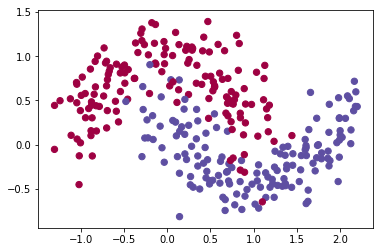

In [18]:
train_X, train_Y = load_dataset()

In [138]:
def model(X, Y, layers_dims, optimizer, learning_rate=0.0007, mini_batch_size=64, beta=0.9,
          beta1=0.9, beta2=0.999, epsilon=1e-8, num_epochs=10000, print_cost=True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "rmsprop":
        s = initialize_rms(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost
            cost = compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "rmsprop":
                parameters, s = update_parameters_with_rmsprop(parameters, grads, s, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print("Cost after epoch %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

Cost after epoch 0: 0.706218
Cost after epoch 1000: 0.622931
Cost after epoch 2000: 0.482653


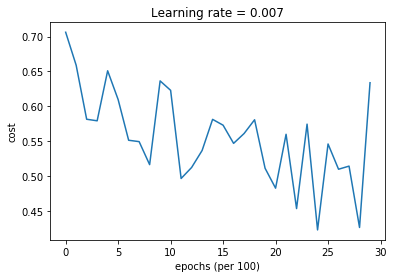

Accuracy: 0.5


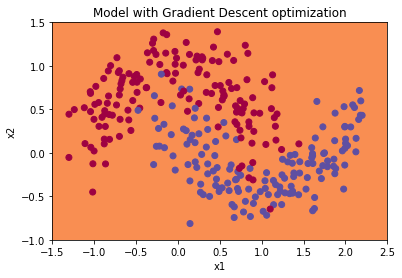

In [119]:
# VANILLA MINI BATCH GRADIENT DESCENT

# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer="gd", learning_rate=0.007, num_epochs=3000)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

L:  4
Cost after epoch 0: 0.706614
Cost after epoch 1000: 0.667610
Cost after epoch 2000: 0.619337
Cost after epoch 3000: 0.621371
Cost after epoch 4000: 0.541800
Cost after epoch 5000: 0.536441
Cost after epoch 6000: 0.537024
Cost after epoch 7000: 0.556854
Cost after epoch 8000: 0.460130
Cost after epoch 9000: 0.557142


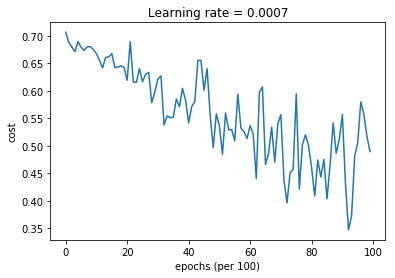

Accuracy: 0.7966666666666666


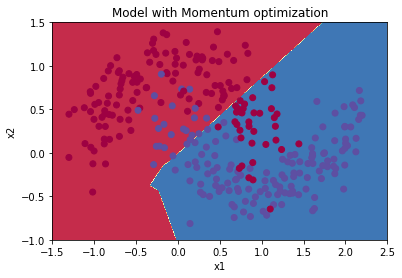

In [67]:
# WITH MOMENTUM

# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta=0.9, optimizer="momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Cost after epoch 0: 0.703518
Cost after epoch 1000: 0.154443
Cost after epoch 2000: 0.096344
Cost after epoch 3000: 0.100901
Cost after epoch 4000: 0.066699
Cost after epoch 5000: 0.169330
Cost after epoch 6000: 0.170996
Cost after epoch 7000: 0.117059
Cost after epoch 8000: 0.118990
Cost after epoch 9000: 0.137595


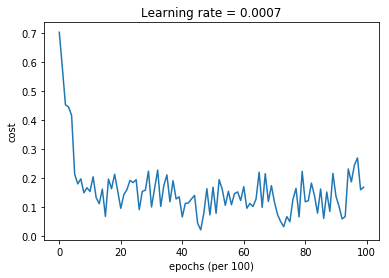

Accuracy: 0.94


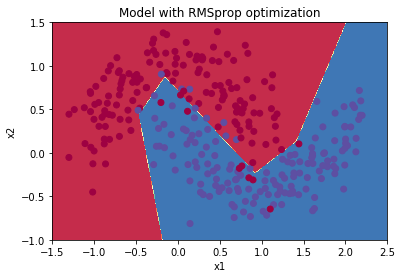

In [135]:
## RMSprop

# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta=0.9, optimizer="rmsprop")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with RMSprop optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Cost after epoch 0: 0.705124
Cost after epoch 1000: 0.145883
Cost after epoch 2000: 0.096292
Cost after epoch 3000: 0.104643
Cost after epoch 4000: 0.067480
Cost after epoch 5000: 0.171954
Cost after epoch 6000: 0.171094
Cost after epoch 7000: 0.115736
Cost after epoch 8000: 0.119551
Cost after epoch 9000: 0.137406


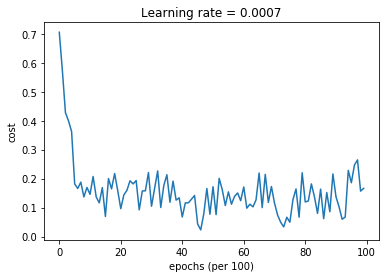

Accuracy: 0.94


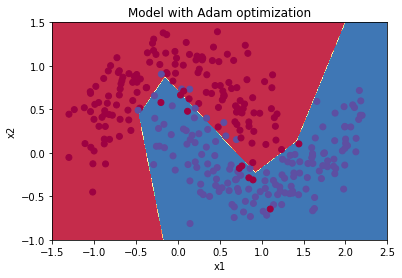

In [142]:
## ADAM

# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer="adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)